# 1. Introduction

In my last notebook on [Natural Language Processing (NLP)](https://github.com/gargimaheshwari/NLP-topic-modelling/blob/master/sklearn.ipynb) I used <code>sklearn</code>'s GridSearch to find the best LDA model for the number of macine learning topics in the NIPS papers. We saw that using <code>search_params</code> over <code>[20, 25, 30, 35]</code> number of topics and <code>[10, 20, 50 ]</code> maximum iterations, the best model turns out to be the one with 20 topics and 50 iterations, with a perplexity of approximately 2453.

Here, I would like to take that analysis further.

An important point to note is that perplexity alone might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words. These can be captured using *topic coherence measure*. I will explore this measure here.

First, I'll load the necessary libraries and the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

papers = pd.read_csv('../input/papers.csv')
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


As before, I will process the database to remove unnecessary fields, and then process the text using the <code>re</code> library.

In [2]:
papers = papers.drop(["id", "event_type", "pdf_name"], axis = 1)

papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))
papers['title_processed'] = papers['title_processed'].map(str.lower)

# 2. Pre-processing 

To further process the data and to ready it for LDA to consume, it needs to be tokenized. However, unlike last time, I will not use <code>sklearn</code>'s resources, but instead I will use NLTK and Gensim. This is because our further analysis of topic coherence uses Gensim's resources, and we need to maintain continuity in the API.

In [3]:
data = [title.split() for title in papers['title_processed']]

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data = remove_stopwords(data)
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

# 3. LDA Topic Coherence measure

An approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The function below trains multiple LDA models and provides the models and their corresponding coherence scores.

In [4]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, data, corpus, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = num_topics,
                                           random_state = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model,
                                        texts = data, 
                                        dictionary = dictionary,
                                        coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Since the last time around we got the ideal number of topics as 20, I will search between 10 and 30 for the ideal number of topics and run the function above. This can take a while to run as the function trains multiple LDA models, however it is not as slow as the GridSearch before.

In [5]:
start = 10; limit = 30; step = 2

model_list, coherence_values = compute_coherence_values(dictionary = id2word, 
                                                        data = data, corpus = corpus, 
                                                        start = start, limit = limit,
                                                        step = step)

I will now plot the coherence values, and choose the optimal model based on the figure.

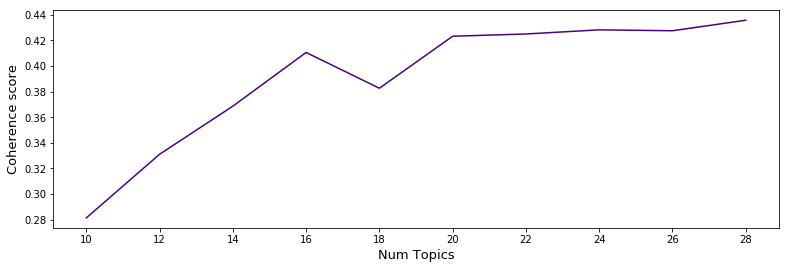

In [6]:
x = range(start, limit, step)
plt.figure(figsize = (13, 4))
plt.plot(x, coherence_values, color = 'indigo')
plt.xlabel("Num Topics", fontsize = 13)
plt.ylabel("Coherence score", fontsize = 13)
plt.xticks(x)
plt.show()

In [7]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 10  has Coherence Value of 0.281
Num Topics = 12  has Coherence Value of 0.331
Num Topics = 14  has Coherence Value of 0.369
Num Topics = 16  has Coherence Value of 0.41
Num Topics = 18  has Coherence Value of 0.383
Num Topics = 20  has Coherence Value of 0.423
Num Topics = 22  has Coherence Value of 0.425
Num Topics = 24  has Coherence Value of 0.428
Num Topics = 26  has Coherence Value of 0.427
Num Topics = 28  has Coherence Value of 0.436


If the coherence score seems to keep increasing, it makes sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself and print out the three most dominant words in each topic.

In [8]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(20, formatted = False)
for i in range(20):
    print((model_topics[i][0] + 1), (list(model_topics[i][1][j][0] for j in range(3))))

1 ['neural', 'network', 'networks']
2 ['completion', 'sparsity', 'cross']
3 ['descent', 'learning', 'data']
4 ['learning', 'power', 'spectral']
5 ['models', 'scalable', 'model']
6 ['distributed', 'inference', 'spike']
7 ['learning', 'supervised', 'sparse']
8 ['rank', 'dynamic', 'learning']
9 ['learning', 'optimal', 'robust']
10 ['learning', 'generative', 'visual']
11 ['learning', 'parallel', 'estimation']
12 ['structure', 'graph', 'large']
13 ['learning', 'variational', 'analysis']
14 ['inference', 'time', 'minimization']
15 ['bandit', 'embedding', 'graphs']
16 ['learning', 'image', 'linear']
17 ['optimization', 'learning', 'stochastic']
18 ['learning', 'carlo', 'monte']
19 ['learning', 'functions', 'stochastic']
20 ['networks', 'neural', 'recurrent']


Finally, as a last step, I will use python's <code>sklearn</code> to create an LDA model with 20 topics, and use the LDA visualizer to view the topics-keywords distribution. A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

The visualization can also be found [here](https://www.kaggleusercontent.com/kf/11723728/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..tBza5OV2QuKjLeuwI7Pu6g.vAFK1cgEFZ2H_8wI43AU8OrslvMsFfUXjuwJbytFBbFMRZbJ2EsoH6c12wA68JekukAJ6O5ZwmRfPekOqwlW6qaBYXuU9aClr7D1Ew_ortSwXXk4UaNxAH5uBAzT_ryUqGxrrhkpb5vKKEDCkqfKgg6CQsYp_aZoTBRJrc3S9Iw.dprXqe26JroP1pwASO43lA/vis.html).

In [9]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words = 'english')
count_data = count_vectorizer.fit_transform(papers['title_processed'])

from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components = 20, random_state = 10)
model = lda.fit(count_data)

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(model, count_data, count_vectorizer, mds='tsne')
saved = pyLDAvis.save_html(vis, fileobj = "vis.html")

![](https://i.imgur.com/H87fvR3.jpg)